# Face Recognition (PCA+SVM)


Based on sklearn example: https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html



In [1]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC



In [2]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [3]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, height, width = lfw_people.images.shape
print(n_samples, height, width)

1288 50 37


In [4]:
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
n_features = X.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print(target_names)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [5]:
# split into a training and testing set
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


In [6]:

def FE_eigenface(X_train0, X_test0, variance_ratio=0.95):
    pca = PCA(variance_ratio, whiten=True)
    X_train_pca = pca.fit_transform(X_train0)
    X_test_pca = pca.transform(X_test0)
    return X_train_pca, X_test_pca, pca

print('extracting eigenface features...')
X_train, X_test, pca = FE_eigenface(X_train_raw, X_test_raw)    



extracting eigenface features...


In [7]:
print('training sample number:', X_train.shape[0])

training sample number: 966


In [8]:

# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 1e4, 1e5],
              'gamma': [0.0001, 0.001, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5, iid=False)
clf = clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)



Fitting the classifier to the training set
done in 10.640s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [9]:
print('test sample number:', X_test.shape[0])

test sample number: 322


In [10]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
mean_f1 = f1_score(y_test, y_pred, average='macro')  
weighted_f1 = f1_score(y_test, y_pred, average='weighted') 
acc = accuracy_score(y_test, y_pred)
print('mean-f1: {:.2f}, weighted-f1: {:.2f}, acc: {:.2f} '.format(mean_f1, weighted_f1, acc))
    

[[  8   0   3   2   0   0   0]
 [  1  52   1   3   0   1   2]
 [  5   0  21   0   0   0   1]
 [  1  12   2 130   0   0   1]
 [  0   2   0   2  21   0   0]
 [  0   2   0   1   3   8   1]
 [  0   3   1   6   0   0  26]]
mean-f1: 0.76, weighted-f1: 0.83, acc: 0.83 


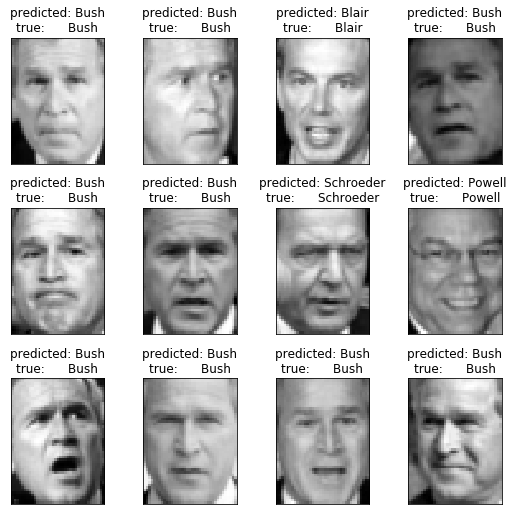

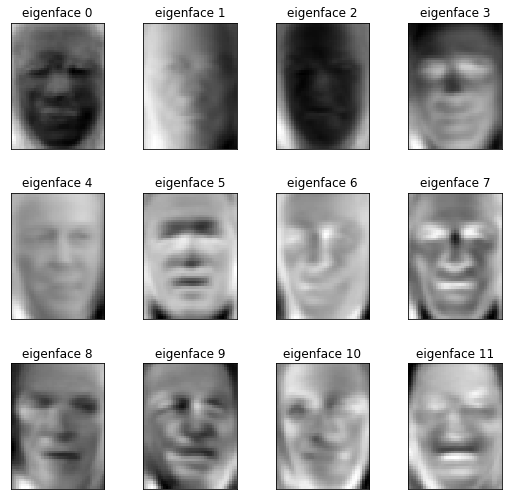

In [11]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test_raw, prediction_titles, height, width)

dim_pca = pca.components_.shape[0]
eigenfaces = pca.components_.reshape((dim_pca, height, width))



# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, height, width)

plt.show()
